# DreamBooth の実装

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/py-img-gen/python-image-generation/blob/main/notebooks/5-1-2_dreambooth.ipynb)

参考: https://huggingface.co/docs/diffusers/training/dreambooth

## 準備

In [ ]:
!pip install -qq py-img-gen[quantization]

In [1]:
import warnings

import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
dtype = torch.float16

warnings.simplefilter("ignore", FutureWarning)

In [2]:
model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
resize_size = 512

In [3]:
import pathlib

current_dir = pathlib.Path.cwd()
project_dir = current_dir / "data" / "dreambooth"
project_dir.mkdir(exist_ok=True, parents=True)
print(f"Created a directory: {project_dir}")

Created a directory: /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/dreambooth


In [4]:
sample_image_dir = project_dir / "sample-images"
sample_image_dir.mkdir(exist_ok=True, parents=True)
print(f"Created a directory: {sample_image_dir}")

Created a directory: /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/dreambooth/sample-images


In [5]:
from typing import List

from diffusers.utils import load_image
from tqdm.auto import tqdm

image_file_paths: List[str] = [
    "https://hf.co/datasets/diffusers/cat_toy_example/resolve/main/1.jpeg",
    "https://hf.co/datasets/diffusers/cat_toy_example/resolve/main/2.jpeg",
    "https://hf.co/datasets/diffusers/cat_toy_example/resolve/main/3.jpeg",
    "https://hf.co/datasets/diffusers/cat_toy_example/resolve/main/4.jpeg",
]


def download_image(
    image_url: str, save_path: pathlib.Path
) -> None:
    print(f"Downloading an image from {image_url}...")
    image = load_image(image_url)
    print(f"Saving the image to {save_path}...")
    image.save(save_path)


def download_images(
    image_urls: List[str], save_dir_path: pathlib.Path
) -> None:
    for i, image_url in tqdm(enumerate(image_urls)):
        save_path = save_dir_path / f"{i}.png"
        download_image(
            image_url=image_url, save_path=save_path
        )


download_images(
    image_urls=image_file_paths,
    save_dir_path=sample_image_dir,
)

0it [00:00, ?it/s]

Saving the image to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/dreambooth/sample-images/0.png...
Saving the image to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/dreambooth/sample-images/1.png...
Saving the image to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/dreambooth/sample-images/2.png...
Saving the image to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/dreambooth/sample-images/3.png...


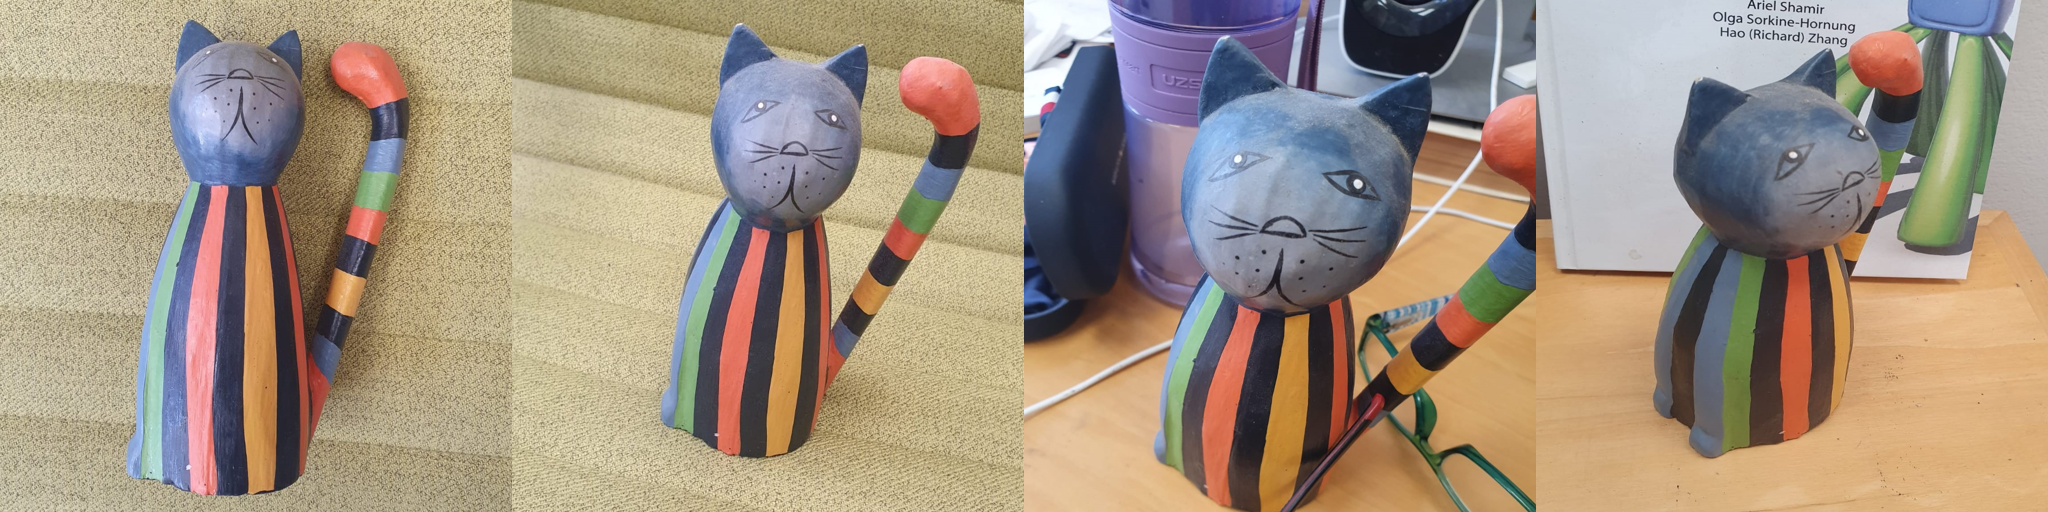

In [6]:
from diffusers.utils import make_image_grid

images = [
    load_image(
        str(path),
        convert_method=lambda im: im.resize(
            (resize_size, resize_size)
        ),
    )
    for path in sample_image_dir.glob("*.png")
]

make_image_grid(images, rows=1, cols=len(images))

In [7]:
instance_prompt = "a photo of sks toy"

is_prior_preservation = False
prior_preservation_class_prompt = "a photo of clay toy"

In [8]:
num_class_images = 12
prior_loss_weight = 0.5

prior_preservation_class_dir = project_dir / "class-images"
prior_preservation_class_dir.mkdir(
    exist_ok=True, parents=True
)
print(
    f"Created a directory: {prior_preservation_class_dir}"
)

Created a directory: /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/dreambooth/class-images


In [9]:
from diffusers import StableDiffusionPipeline
from py_img_gen.training.utils import flush_gpu_memory


def generate_class_images(
    model_id: str,
    dtype: torch.dtype,
    device: torch.device,
    prompt: str,
    output_dir: pathlib.Path,
    num_class_images: int,
    batch_size: int = 2,
) -> None:
    cur_class_images = len(list(output_dir.iterdir()))
    if cur_class_images >= num_class_images:
        return

    pipe = StableDiffusionPipeline.from_pretrained(
        model_id, torch_dtype=dtype
    )
    pipe = pipe.to(device)

    pipe.enable_attention_slicing()
    pipe.set_progress_bar_config(disable=True)

    num_new_images = num_class_images - cur_class_images
    print(
        f"Number of class images to sample: {num_new_images}"
    )

    for idx in tqdm(
        range(0, num_new_images, batch_size),
        desc="Generating class images",
    ):
        output = pipe(
            prompt=prompt,
            num_images_per_prompt=batch_size,
        )
        images = output.images

        for i, image in enumerate(images):
            save_path = (
                output_dir
                / f"{cur_class_images + idx + i}.png"
            )
            print(f"Saving the image to `{save_path}`")
            image.save(save_path)

    flush_gpu_memory(
        pipe.scheduler,
        pipe.text_encoder,
        pipe.tokenizer,
        pipe.unet,
        pipe.vae,
        pipe,
    )


if is_prior_preservation:
    generate_class_images(
        model_id=model_id,
        dtype=dtype,
        device=device,
        prompt=prior_preservation_class_prompt,
        output_dir=prior_preservation_class_dir,
        num_class_images=num_class_images,
    )

In [10]:
from dataclasses import dataclass
from typing import Optional, TypedDict

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset
from transformers import CLIPTokenizer
from transformers.tokenization_utils_base import (
    BatchEncoding,
)


def tokenize_prompt(
    prompt: str, tokenizer: CLIPTokenizer
) -> BatchEncoding:
    max_length = tokenizer.model_max_length
    return tokenizer(
        text=prompt,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
    )


class Example(TypedDict):
    images: torch.Tensor
    prompt_ids: torch.Tensor


class DreamBoothExample(TypedDict):
    instance: Example
    classes: Optional[Example]


@dataclass
class DreamBoothDataset(Dataset):
    instance_data_root: pathlib.Path
    instance_prompt: str
    tokenizer: CLIPTokenizer
    class_data_root: Optional[pathlib.Path] = None
    class_prompt: Optional[str] = None
    image_size: int = 512
    is_center_crop: bool = False

    _instance_image_paths: Optional[List[pathlib.Path]] = (
        None
    )
    _class_image_paths: Optional[List[pathlib.Path]] = None
    _image_transforms: Optional[T.Compose] = None

    def __post_init__(self) -> None:
        assert self.instance_data_root.exists()
        self._instance_image_paths = list(
            self.instance_data_root.iterdir()
        )

    @property
    def instance_image_paths(self) -> List[pathlib.Path]:
        assert self._instance_image_paths is not None
        return self._instance_image_paths

    @property
    def class_image_paths(
        self,
    ) -> Optional[List[pathlib.Path]]:
        if self.class_data_root is None:
            return None

        return list(self.class_data_root.iterdir())

    @property
    def num_instance_images(self) -> int:
        return len(self.instance_image_paths)

    @property
    def num_class_images(self) -> int:
        return (
            len(self.class_image_paths)
            if self.class_image_paths is not None
            else 0
        )

    @property
    def dataset_length(self) -> int:
        return max(
            self.num_instance_images, self.num_class_images
        )

    @property
    def image_transforms(self) -> T.Compose:
        transforms = [
            T.Resize(self.image_size),
            T.CenterCrop(self.image_size)
            if self.is_center_crop
            else T.RandomCrop(self.image_size),
            T.ToTensor(),
            T.Normalize([0.5], [0.5]),
        ]
        return T.Compose(transforms)

    def get_example(
        self,
        idx: int,
        image_paths: List[pathlib.Path],
        num_images: int,
        prompt: str,
    ) -> Example:
        #
        # 画像の読み込み
        #
        image_path = image_paths[idx % num_images]
        image = load_image(str(image_path))
        image_th = self.image_transforms(image)
        assert isinstance(image_th, torch.Tensor)

        #
        # プロンプトのトークナイズ
        #
        text_inputs = tokenize_prompt(
            prompt=prompt, tokenizer=self.tokenizer
        )

        return {
            "images": image_th,
            "prompt_ids": text_inputs.input_ids,
        }

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> DreamBoothExample:
        #
        # Instance データの取得
        #
        instance_example = self.get_example(
            idx,
            image_paths=self.instance_image_paths,
            num_images=self.num_instance_images,
            prompt=self.instance_prompt,
        )
        if self.class_data_root is None:
            return {
                "instance": instance_example,
                "classes": None,
            }
        #
        # Class データも使用する場合
        #
        assert (
            self.class_image_paths is not None
            and self.class_prompt is not None
        )
        class_example = self.get_example(
            idx,
            image_paths=self.class_image_paths,
            num_images=self.num_class_images,
            prompt=self.class_prompt,
        )
        return {
            "instance": instance_example,
            "classes": class_example,
        }

In [11]:
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    UNet2DConditionModel,
)
from transformers import CLIPTextModel, CLIPTokenizer

text_encoder = CLIPTextModel.from_pretrained(
    model_id,
    subfolder="text_encoder",
)
vae = AutoencoderKL.from_pretrained(
    model_id,
    subfolder="vae",
)
unet = UNet2DConditionModel.from_pretrained(
    model_id,
    subfolder="unet",
)
tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
)
noise_scheduler = DDPMScheduler.from_pretrained(
    model_id,
    subfolder="scheduler",
)

In [12]:
class_data_root = (
    prior_preservation_class_dir
    if is_prior_preservation
    else None
)
class_prompt = (
    prior_preservation_class_prompt
    if is_prior_preservation
    else None
)
train_dataset = DreamBoothDataset(
    instance_data_root=sample_image_dir,
    instance_prompt=instance_prompt,
    tokenizer=tokenizer,
    class_data_root=class_data_root,
    class_prompt=class_prompt,
    image_size=resize_size,
    is_center_crop=True,
)

In [13]:
sd_dreambooth_dir = project_dir / "sd-dreambooth-output"


@dataclass
class Hyperparameter(object):
    learning_rate: float = 1e-5
    max_train_steps: int = 400
    train_text_encoder: bool = False
    # 事前知識の保存を行う場合はバッチサイズを `1` にしてください
    train_batch_size: int = 1

    gradient_accumulation_steps: int = 1
    gradient_checkpointing: bool = True
    max_grad_norm: float = 1.0
    mixed_precision: str = "fp16"

    # `bitsandbytes` による 8-bit 最適化を利用する場合は `True` にしてください
    use_8bit_adam: bool = True

    seed: int = 19950815
    lr_scheduler: str = "constant"
    lr_warmup_steps: int = 100
    output_dir_path: pathlib.Path = sd_dreambooth_dir


hparams = Hyperparameter()
hparams

Hyperparameter(learning_rate=1e-05, max_train_steps=400, train_text_encoder=False, train_batch_size=1, gradient_accumulation_steps=1, gradient_checkpointing=True, max_grad_norm=1.0, mixed_precision='fp16', use_8bit_adam=True, seed=19950815, lr_scheduler='constant', lr_warmup_steps=100, output_dir_path=PosixPath('/root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/dreambooth/sd-dreambooth-output'))

In [14]:
import itertools

from accelerate import Accelerator
from accelerate.utils import set_seed
from diffusers.optimization import get_scheduler


class BatchDict(TypedDict):
    input_ids: torch.Tensor
    pixel_values: torch.Tensor


def collate_fn(
    examples: List[DreamBoothExample],
    is_prior_preservation: bool,
) -> BatchDict:
    input_ids = [
        example["instance"]["prompt_ids"]
        for example in examples
    ]
    pixel_values = [
        example["instance"]["images"]
        for example in examples
    ]

    # 事前保存のためにクラスとインスタンスの例を concat する
    # 以下の操作によりミニバッチ化して 2 回の順伝播を行うのを避ける
    if is_prior_preservation:
        for example in examples:
            class_example = example["classes"]
            assert class_example is not None
            input_ids.append(class_example["prompt_ids"])
            pixel_values.append(class_example["images"])

    pixel_values_th = torch.stack(pixel_values).to(
        memory_format=torch.contiguous_format,
        dtype=torch.float32,
    )
    input_ids_th = torch.cat(input_ids, dim=0)

    return {
        "input_ids": input_ids_th,
        "pixel_values": pixel_values_th,
    }

In [15]:
from typing import Dict

import torch.nn.functional as F
from torch.utils.data import DataLoader


def training_function(
    text_encoder: CLIPTextModel,
    vae: AutoencoderKL,
    unet: UNet2DConditionModel,
):
    # 学習の再現性を確保するために乱数の seed を固定
    set_seed(hparams.seed)

    # 学習を効率化する Accelerator の設定
    accelerator = Accelerator(
        gradient_accumulation_steps=hparams.gradient_accumulation_steps,
        mixed_precision=hparams.mixed_precision,
    )
    print(accelerator.state)

    # VAE のパラメータを固定
    vae.requires_grad_(False)
    # Text Encoder のパラメータを固定するか判定
    if not hparams.train_text_encoder:
        text_encoder.requires_grad_(False)

    if hparams.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if hparams.train_text_encoder:
            text_encoder.gradient_checkpointing_enable()

    # Colab の T5 GPU のような、16 GB 以下の GPU RAM の場合は
    # fine-tuning 時のメモリ使用量を減らすために 8-bit の Adam optimizer を使用
    if hparams.use_8bit_adam:
        import bitsandbytes as bnb

        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    params_to_optimize = (
        itertools.chain(
            unet.parameters(), text_encoder.parameters()
        )
        if hparams.train_text_encoder
        else unet.parameters()
    )
    optimizer = optimizer_class(
        params_to_optimize,
        lr=hparams.learning_rate,
    )

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=hparams.train_batch_size,
        shuffle=True,
        collate_fn=lambda x: collate_fn(
            x, is_prior_preservation
        ),
    )

    lr_scheduler = get_scheduler(
        hparams.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=hparams.lr_warmup_steps
        * hparams.gradient_accumulation_steps,
        num_training_steps=hparams.max_train_steps
        * hparams.gradient_accumulation_steps,
    )

    if hparams.train_text_encoder:
        (
            unet,
            text_encoder,
            optimizer,
            train_data_loader,
            lr_scheduler,
        ) = accelerator.prepare(
            unet,
            text_encoder,
            optimizer,
            train_data_loader,
            lr_scheduler,
        )
    else:
        unet, optimizer, train_data_loader, lr_scheduler = (
            accelerator.prepare(
                unet,
                optimizer,
                train_data_loader,
                lr_scheduler,
            )
        )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # VAE と Text Encoder を GPU に移動
    # Mixed Precision Training (混合精度学習) のために、`vae` と `text_encoder` の重みを
    # 半精度 (float16) にキャストします。これらのモデルは推論にのみ使用されるため
    # 単精度 (float32) の重みである必要はありません
    vae.to(accelerator.device, dtype=weight_dtype)
    vae.decoder.to("cpu")
    if not hparams.train_text_encoder:
        text_encoder.to(
            accelerator.device, dtype=weight_dtype
        )

    # Train!
    total_batch_size = (
        hparams.train_batch_size
        * accelerator.num_processes
        * hparams.gradient_accumulation_steps
    )

    print("***** Running training *****")
    print(f"  Num examples = {len(train_dataset)}")
    print(
        f"  Instantaneous batch size per device = {hparams.train_batch_size}"
    )
    print(
        f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}"
    )
    print(
        f"  Gradient Accumulation steps = {hparams.gradient_accumulation_steps}"
    )
    print(
        f"  Total optimization steps = {hparams.max_train_steps}"
    )

    progress_bar = tqdm(
        range(hparams.max_train_steps),
        disable=not accelerator.is_local_main_process,
        desc="Steps",
    )

    global_step = 0
    train_data_iter = iter(train_data_loader)

    while global_step != hparams.max_train_steps:
        try:
            batch = next(train_data_iter)
        except StopIteration:
            train_data_iter = iter(train_data_loader)
            batch = next(train_data_iter)

        if hparams.train_text_encoder:
            text_encoder.train()

        unet.train()  # UNet は常に学習モードにする

        with accelerator.accumulate(unet):
            loss = train_step(
                batch=batch,
                text_encoder=text_encoder,
                vae=vae,
                unet=unet,
                noise_scheduler=noise_scheduler,
                weight_dtype=weight_dtype,
                accelerator=accelerator,
                optimizer=optimizer,
                lr_scheduler=lr_scheduler,
            )

        # accelerator がバックグラウンドで最適化工程を実行したかを確認
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1

        logs = {"loss": loss.detach().item()}
        progress_bar.set_postfix(**logs)

    accelerator.wait_for_everyone()

    # 学習したモデルを元に、pipeline を構築して保存
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            model_id,
            unet=accelerator.unwrap_model(unet),
            text_encoder=accelerator.unwrap_model(
                text_encoder
            ),
        )
        print(
            f"Saving the trained pipeline to {hparams.output_dir_path}"
        )
        pipeline.save_pretrained(hparams.output_dir_path)


def train_step(
    batch: Dict[str, torch.Tensor],
    text_encoder: CLIPTextModel,
    vae: AutoencoderKL,
    unet: UNet2DConditionModel,
    noise_scheduler: DDPMScheduler,
    weight_dtype: torch.dtype,
    accelerator: Accelerator,
    optimizer: torch.optim.Optimizer,
    lr_scheduler: torch.optim.lr_scheduler.LambdaLR,
) -> torch.Tensor:
    # 画像を潜在表現へ変換
    pixel_values = batch["pixel_values"].to(
        dtype=weight_dtype
    )
    latents = vae.encode(pixel_values).latent_dist.sample()
    latents *= vae.config.scaling_factor

    # 潜在表現へ追加するノイズを取得
    noise = torch.randn_like(latents)
    bsz = latents.shape[0]
    # 各画像に対してランダムなタイムステップ数を取得
    timesteps = torch.randint(
        0,
        noise_scheduler.config.num_train_timesteps,
        (bsz,),
        device=latents.device,
    )
    timesteps = timesteps.long()

    # 各タイムステップにおけるノイズの大きさに従って
    # 潜在表現にノイズを追加 (拡散過程)
    noisy_latents = noise_scheduler.add_noise(
        latents, noise, timesteps
    )

    # 条件付のためのプロンプトからテキストベクトルを取得
    encoder_hidden_states = text_encoder(
        batch["input_ids"]
    )[0]

    # ノイズを予測
    noise_pred = unet(
        noisy_latents, timesteps, encoder_hidden_states
    ).sample

    # 予測タイプに応じた損失を計算
    if noise_scheduler.config.prediction_type == "epsilon":
        target = noise
    elif (
        noise_scheduler.config.prediction_type
        == "v_prediction"
    ):
        target = noise_scheduler.get_velocity(
            sample=latents, noise=noise, timesteps=timesteps
        )
    else:
        raise ValueError(
            f"Unknown prediction type {noise_scheduler.config.prediction_type}"
        )

    # 概念の事前知識を忘却しないための class に対する学習
    if is_prior_preservation:
        # 追加したノイズ `noise` と 予測したノイズ`noise_pred` を
        # 2 つの部分に分けて、それぞれの部分で別々の損失を計算
        noise_pred, noise_pred_prior = torch.chunk(
            input=noise_pred, chunks=2, dim=0
        )
        target, target_prior = torch.chunk(
            input=target, chunks=2, dim=0
        )
        # 追加概念に対する損失を計算
        prior_loss = F.mse_loss(
            noise_pred_prior.float(),
            target_prior.float(),
            reduction="mean",
        )

    # instance に対する学習
    loss = F.mse_loss(
        noise_pred.float(), target.float(), reduction="mean"
    )
    if is_prior_preservation:
        # class に対する損失を追加
        loss += prior_loss_weight * prior_loss

    # Backpropagationを実施
    accelerator.backward(loss)

    if accelerator.sync_gradients:
        params_to_clip = (
            itertools.chain(
                unet.parameters(),
                text_encoder.parameters(),
            )
            if hparams.train_text_encoder
            else unet.parameters()
        )
        accelerator.clip_grad_norm_(
            params_to_clip, hparams.max_grad_norm
        )

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

    return loss

In [16]:
import accelerate

accelerate.notebook_launcher(
    training_function,
    args=(text_encoder, vae, unet),
    num_processes=1,
)

for param in itertools.chain(
    unet.parameters(), text_encoder.parameters()
):
    if param.grad is not None:
        # Colab では RAM の制約があるため勾配に関する情報を削除
        del param.grad
    torch.cuda.empty_cache()

Launching training on one GPU.
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

***** Running training *****
  Num examples = 4
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 400


  0%|          | 0/400 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
from diffusers import DPMSolverMultistepScheduler

print(
    f"Loading the pre-trained components from {hparams.output_dir_path}"
)

scheduler = DPMSolverMultistepScheduler.from_pretrained(
    hparams.output_dir_path,
    subfolder="scheduler",
)
pipe = StableDiffusionPipeline.from_pretrained(
    hparams.output_dir_path,
    scheduler=scheduler,
    torch_dtype=dtype,
)
pipe = pipe.to(device)

Loading the pre-trained components from /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/dreambooth/sd-dreambooth-output


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

a photo of sks backpack


  0%|          | 0/25 [00:00<?, ?it/s]

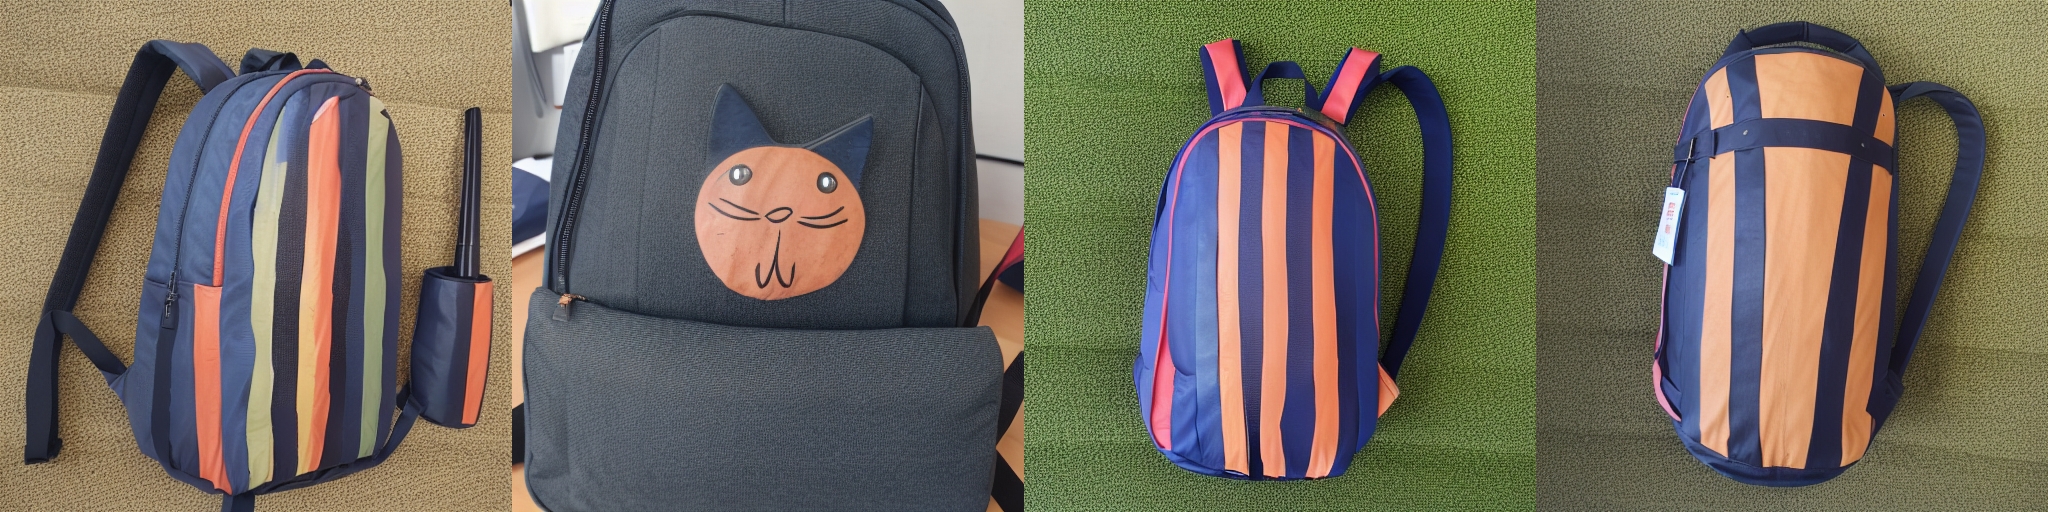

In [25]:
prompt = "a photo of sks backpack"
print(prompt)

output = pipe(
    prompt=prompt,
    num_images_per_prompt=4,
    generator=torch.manual_seed(42),
    num_inference_steps=25,
)
images = output.images
make_image_grid(images=images, rows=1, cols=len(images))